# A. Loading the required libraries 
- importing standard python libraries 
- importing self written utils functions 
- declaring paths for finding data and saving text and images 

In [48]:
# Import the required libraries

# Data manipulation and math operations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt  # For Matplotlib visualizations
import seaborn as sns            # For Seaborn visualizations
import plotly.express as px      # For interactive visualizations with Plotly
# %matplotlib inline  # Uncomment for Jupyter notebooks to display plots inline

# System libraries
import warnings
import sys
import os
import inspect
# Ignore all warnings (useful for ignoring non-critical warnings)
warnings.filterwarnings("ignore")

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import utils library with custom functions
from utils_finance import *
import utils_finance
import importlib

importlib.reload(utils_finance)

text_outputs = []



In [49]:
# Path to the neighboring 'plots' folder in the local repository
plots_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'plots'))
print(plots_path)


# Path to the neighboring 'data' folder in the local repository
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
print(data_path)

# Path to the neighboring 'reports' folder in the local repository where the conclusive report will be saved as a pdf 
report_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports'))
print(report_path)


/Users/tillo/Repositoriums/FinanceGrouper/plots
/Users/tillo/Repositoriums/FinanceGrouper/data
/Users/tillo/Repositoriums/FinanceGrouper/reports


# B. Data management: Finding, loading and concat all years of the data, saving it 

In [50]:
# Retrieving data

# CSV files from DKB have a cryptic header; skip the first rows to make it readable
headerSize = 4

# List to store each DataFrame for later concatenation
dataframes = []

# Iterate through all files in the Data directory
for filename in os.listdir(data_path):
    # Skip "Data_All_Years.csv" if it already exists
    if filename == "Data_All_Years.csv":
        continue
    # Skip the training data for the ML model
    if filename == "Training_Data.csv":
        continue
    
    # Check if the file is a .csv file
    if filename.endswith('.csv'):
        # Create the full path to the file
        file_path = os.path.join(data_path, filename)

        # Extract the last 4 digits of the filename (assuming they represent the year)
        last_four_digits = filename[-8:-4]
        
        # Make the year variable
        year = int(last_four_digits)

        # Read the .csv file into a DataFrame
        print(f"Reading file: {file_path}")
        df = pd.read_csv(file_path, sep=',', skiprows=headerSize, header=0, encoding='utf-8-sig')

        # Save the DataFrame under a dynamic name
        globals()[f'df_{last_four_digits}'] = df

        # Append the DataFrame to the list for concatenation
        dataframes.append(df)

        # Display the shape and column names of the DataFrame
        print('Shape:', df.shape)
        print('Column names:', df.columns)

# Concatenate all data to a single DataFrame
df_all_years = pd.concat(dataframes, ignore_index=True)

# Save the concatenated DataFrame to "Data_All_Years.csv"
output_path = os.path.join(data_path, "Data_All_Years.csv")
df_all_years.to_csv(output_path, index=False, sep=';')
print(f"Concatenated DataFrame saved to: {output_path}")


df = df_all_years

Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_transactions_2024.csv
Shape: (551, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBAN',
       'Betrag (€)', 'Gläubiger-ID', 'Mandatsreferenz', 'Kundenreferenz'],
      dtype='object')
Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_transactions_2023.csv
Shape: (533, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBAN',
       'Betrag (€)', 'Gläubiger-ID', 'Mandatsreferenz', 'Kundenreferenz'],
      dtype='object')
Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_Transactions_2022.csv
Shape: (437, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBAN',
       'Betrag

In [51]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 1521 rows, 12 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status Zahlungspflichtige*r  \
0      25.10.24     25.10.24  Gebucht               ISSUER   
1      25.10.24     25.10.24  Gebucht     Tillmann Stralka   
2      24.10.24     24.10.24  Gebucht               ISSUER   
3      23.10.24     23.10.24  Gebucht               ISSUER   
4      23.10.24     23.10.24  Gebucht               ISSUER   

            Zahlungsempfänger*in  \
0    PAYPAL..EBAY.DE/35314369001   
1  AMAZON PAYMENTS EUROPE S.C.A.   
2      SPORTPARK.LEIPZIG/LEIPZIG   
3                         Konsum   
4                  Deutsche Bahn   

                                    Verwendungszweck Umsatztyp  \
0                             VISA Debitkartenumsatz   Ausgang   
1  304-5350210-5156366 AMZN Mktp DE 600VIXZVWCAJCOLH   Ausgang   
2                             VISA Debitkartenumsatz   Ausgang   
3                             VISA Debitka

# C. First cleaning of data set
+ deleting empty rows and columns 
+ fixing Euro ',' and '.' problem in numbers 
+ changing type of columns to numerical (floats) and types (object)
+ filter all entrances which have very long empty entrys and make them to only one ' '

In [52]:
### Deleting empty columns and rows for each df before saving it in a global variable 
# Identify columns that contain only NaN values
nan_columns = df.columns[df.isna().all()].tolist()    
# Drop the columns with only NaN values
df.drop(columns=nan_columns, inplace=True)
# Delete all rows that are completely empty (i.e., contain only NaN values)
empty_rows = df[df.isna().all(axis=1)].index
df.drop(index=empty_rows, inplace=True)

Set type of data of the columns 

In [53]:
# Fix US / EU decimal-point/comma
df['Betrag (€)'] = df['Betrag (€)'].str.replace('.','')
df['Betrag (€)'] = df['Betrag (€)'].str.replace(',','.')


In [54]:

# All columns will be set accordingly as dtype to what sort of stuff they contain 
df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'], format='%d.%m.%y', errors='coerce')
df['Wertstellung'] = pd.to_datetime(df['Wertstellung'], format='%d.%m.%y', errors='coerce')
df['Status'] = df['Status'].astype('category')
df['Zahlungspflichtige*r'] = df['Zahlungspflichtige*r'].astype('string')
df['Zahlungsempfänger*in'] = df['Zahlungsempfänger*in'].astype('string')
df['Verwendungszweck'] = df['Verwendungszweck'].astype('string')
df['Umsatztyp'] = df['Umsatztyp'].astype('category')
df['IBAN'] = df['IBAN'].astype('string')

# Make sure euro is set to string 
df['Betrag (€)'] = df['Betrag (€)'].astype(float)

df['Gläubiger-ID'] = df['Gläubiger-ID'].astype('string')
df['Mandatsreferenz'] = df['Mandatsreferenz'].astype('string')
df['Kundenreferenz'] = df['Kundenreferenz'].astype('string')

#Check if it worked 
inspect_data(df)


🚀 Basic Data Overview
🗂 Shape of the DataFrame: 1521 rows, 12 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status Zahlungspflichtige*r  \
0    2024-10-25   2024-10-25  Gebucht               ISSUER   
1    2024-10-25   2024-10-25  Gebucht     Tillmann Stralka   
2    2024-10-24   2024-10-24  Gebucht               ISSUER   
3    2024-10-23   2024-10-23  Gebucht               ISSUER   
4    2024-10-23   2024-10-23  Gebucht               ISSUER   

            Zahlungsempfänger*in  \
0    PAYPAL..EBAY.DE/35314369001   
1  AMAZON PAYMENTS EUROPE S.C.A.   
2      SPORTPARK.LEIPZIG/LEIPZIG   
3                         Konsum   
4                  Deutsche Bahn   

                                    Verwendungszweck Umsatztyp  \
0                             VISA Debitkartenumsatz   Ausgang   
1  304-5350210-5156366 AMZN Mktp DE 600VIXZVWCAJCOLH   Ausgang   
2                             VISA Debitkartenumsatz   Ausgang   
3                             VISA Debitka

In [55]:
# Function to replace multiple spaces and new lines with a single space
df = reduce_multiple_spaces_and_newlines(df)

# D. Analysis of the financial data

# D. 1 Basic analysis of the data 
+ Calculate total income and expenses.
+ Determine monthly savings (income minus expenses).
+ Identify the largest expenses and sources of income.

In [56]:
# Performs basic financial analysis including total income, expenses, and largest transactions
text_1 = basic_analysis(df)
print(text_1)

Total Income: €67817.88
Total Expenses: €-69382.54

Monthly Savings:
month
2022-01    1406.19
2022-02     605.79
2022-03     226.67
2022-04    -730.55
2022-05   -1215.11
2022-06    -135.91
2022-07    -753.87
2022-08     801.41
2022-09     -50.73
2022-10    -119.88
2022-11    1730.14
2022-12     782.42
2023-01    -333.00
2023-02     -62.90
2023-03   -1029.69
2023-04   -1349.30
2023-05    -439.47
2023-06     141.61
2023-07     238.90
2023-08     685.58
2023-09     704.10
2023-10     108.34
2023-11    -215.20
2023-12     244.48
2024-01    -385.58
2024-02     340.06
2024-03      22.56
2024-04     -44.28
2024-05    -128.19
2024-06    -237.64
2024-07    -371.27
2024-08    -201.87
2024-09    -161.68
2024-10   -1636.79
Freq: M

Largest Expense:
Buchungsdatum Zahlungsempfänger*in  Betrag (€)
   2022-08-17             MITOS AE     -1660.0

Largest Income:
Buchungsdatum Zahlungspflichtige*r  Betrag (€)
   2024-03-28        Compl3te GmbH     2329.69

Most frequent income source: Hauptkasse des Fre

# D. 2 Income and Expense Categorization
+ Categorize transactions by Umsatztyp (e.g., groceries, rent, salary) to provide a breakdown of expenses and income per category. 
+ This helps understand which categories contribute the most to expenses and income.

In [57]:
# Group by 'Umsatztyp' and calculate total income and expenses per category
text_2 = analyze_by_category(df)
print(text_2)

Total by Category:
Umsatztyp
Ausgang   -69382.54
Eingang    67817.88


# D. 3 Income vs Expense Trend Over Time 
+ Create a time series analysis to visualize income and expenses trends over time (e.g., monthly, quarterly).


'/Users/tillo/Repositoriums/FinanceGrouper/plots/income_expense_trend.png'

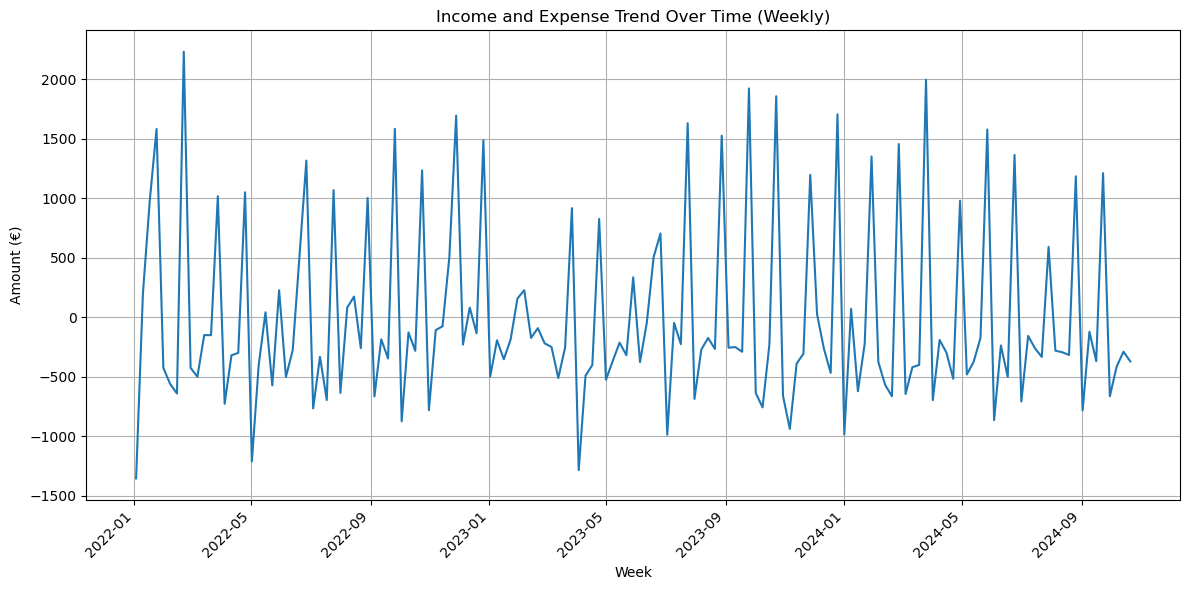

In [58]:
# Creates a time series analysis of income and expenses over time
income_expense_trend(df, plots_path)


# D 4. Average Monthly Income/Expense
Calculate the average monthly income and expense to get an overall view of typical monthly financial activity.

In [59]:
# Calculates average monthly income and expenses.
average_monthly_stats(df)


Average Monthly Income: €2055.09
Average Monthly Expenses: €-2040.66


# D 5. Recurring Transactions Detection
Identify recurring transactions such as regular payments (e.g., rent, subscriptions) or income (e.g., salary) based on similar amounts and descriptions.

In [60]:
# Identifies recurring transactions based on recipient and amount
# Call the function and display the first few rows of the recurring transactions
recurring, recurring_summary = detect_recurring_transactions(df)
recurring_summary.head()

,Zahlungsempfänger*in,Betrag (€),Count
69,"Telefonica Germany G Georg-Brauchle-Ring 50, 8...",-9.99,23
16,Boulderhalle Leipzig Gm,-8.00,13
70,Tillmann Stralka,-447.00,12
67,TILLMANN STRALKA,-200.00,11
68,TILLMANN STRALKA,-50.00,11


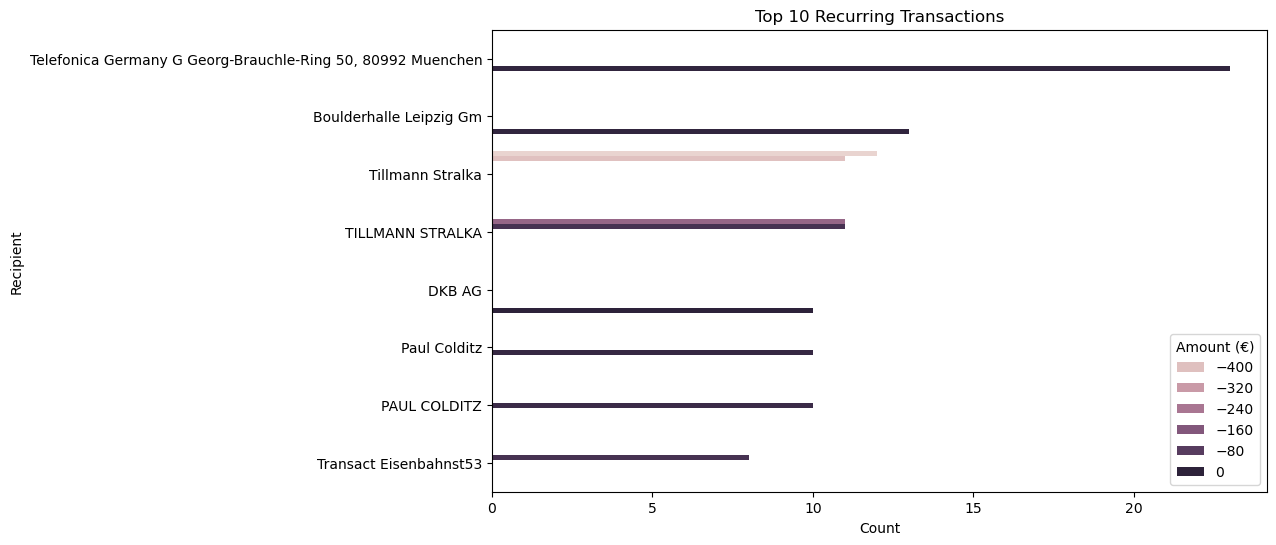

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_recurring_summary.png'

In [61]:
# Visualizes the top recurring transactions in a bar plot
plot_recurring_summary(recurring_summary, plots_path)

# D. 6 Monthly Expense to Income Ratio
Calculate the expense-to-income ratio to determine how much of your income is spent each month.

In [62]:
# Calculates the expense-to-income ratio per month
expense_income_ratio(df)



Expense to Income Ratio per Month:
month
2022-01    0.637878
2022-02    0.728733
2022-03    0.856827
2022-04    1.387932
2022-05    1.645240
2022-06    1.082684
2022-07    1.473156
2022-08    0.808882
2022-09    1.027962
2022-10    1.072337
2022-11    0.498644
2022-12    0.662393
2023-01    1.333333
2023-02    1.023736
2023-03    2.030721
2023-04    2.350651
2023-05    1.439910
2023-06    0.915200
2023-07    0.892981
2023-08    0.679234
2023-09    0.670569
2023-10    0.949310
2023-11    1.100687
2023-12    0.899693
2024-01    1.128217
2024-02    0.876711
2024-03    0.990316
2024-04    1.019829
2024-05    1.059286
2024-06    1.137575
2024-07    1.286407
2024-08    1.151066
2024-09    1.124724
2024-10    0.000000
Freq: M, Name: Betrag (€), dtype: float64


# D. 7 Expense Breakdown by Vendor/Recipient
Provide a breakdown of total expenses by Zahlungsempfänger*in to identify who you are spending the most money on.

In [63]:
# Provides a breakdown of expenses by recipient
expenses_by_recipient(df)


Expenses by Recipient:
Zahlungsempfänger*in
Tillmann Stralka                   -10693.00
MICHAEL STEUBING                    -4050.00
DKB VISACARD                        -3104.69
3273 Konsum Rosa Luxemb             -2768.76
TILLMANN STRALKA                    -2750.00
                                      ...   
SumUp .Das Unikat GmbH                 -1.20
THE.FRUITS.THE.EART/TEL.AVIV...Y       -1.14
Michael.Lind/Berlin                    -1.07
AMPM/TEL.AVIV                          -0.90
ASPIT DIREZ. USCITA -                  -0.80
Name: Betrag (€), Length: 535, dtype: float64


# D. 8 Outlier Detection
Identify unusually large transactions by detecting outliers (e.g., large expenses that are significantly different from the average).

In [64]:
# Identifies unusual transactions using standard deviation
detect_outliers(df)


Outliers:
     Buchungsdatum  Betrag (€)  \
46      2024-09-27     1296.30   
89      2024-08-29      993.83   
122     2024-07-30     1296.30   
177     2024-06-28     1079.20   
236     2024-05-31     2158.24   
291     2024-04-30     2158.24   
356     2024-03-28     2329.69   
422     2024-02-29     2158.24   
499     2024-01-30     2158.24   
553     2023-12-28     2137.32   
606     2023-11-29     2137.32   
650     2023-10-26     2137.32   
707     2023-09-28     2137.32   
751     2023-08-30     2137.32   
803     2023-07-27     2137.32   
893     2023-05-30      999.00   
928     2023-04-27      999.00   
978     2023-03-30      999.00   
996     2023-02-27      999.00   
1020    2023-02-07    -1093.26   
1022    2023-02-06     1601.00   
1038    2023-01-30      999.00   
1087    2022-12-29     1643.75   
1129    2022-11-29     2196.23   
1176    2022-10-27     1593.28   
1209    2022-09-29     1814.28   
1250    2022-08-30     1593.28   
1266    2022-08-17    -1660.00   
126

# D. 9 Savings Percentage
Calculate the percentage of income saved each month.

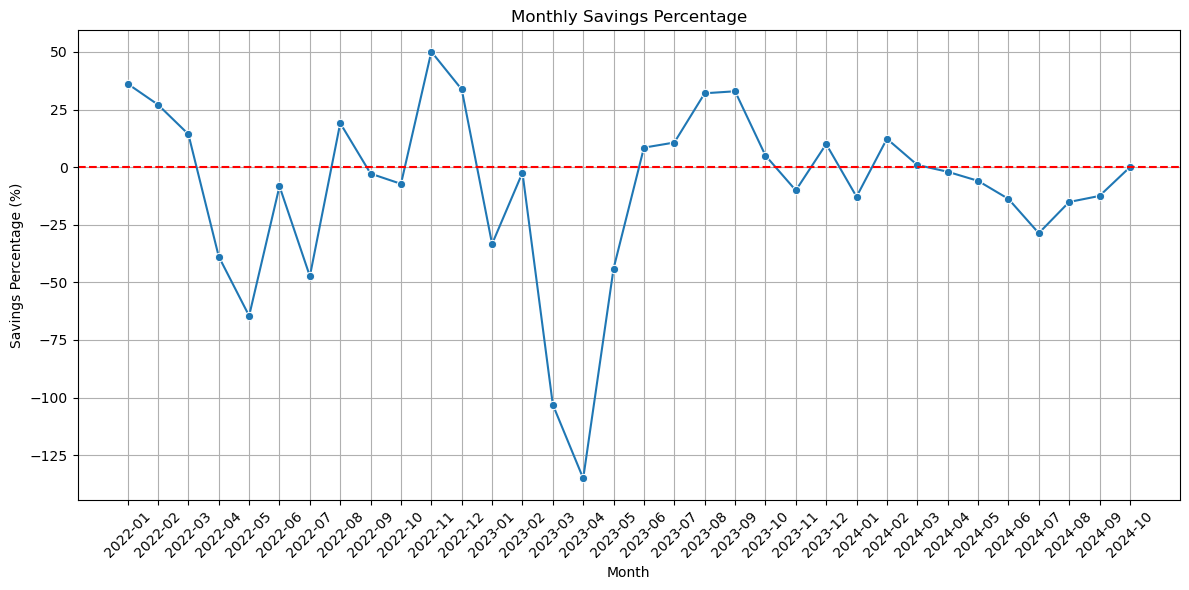

'/Users/tillo/Repositoriums/FinanceGrouper/plots/savings_percentage.png'

In [65]:
# Calculates and visualizes monthly savings percentage
savings_percentage(df, plots_path)

# D. 10 Cash Flow Stability
Calculate cash flow volatility to measure the consistency of your monthly income and expenses.

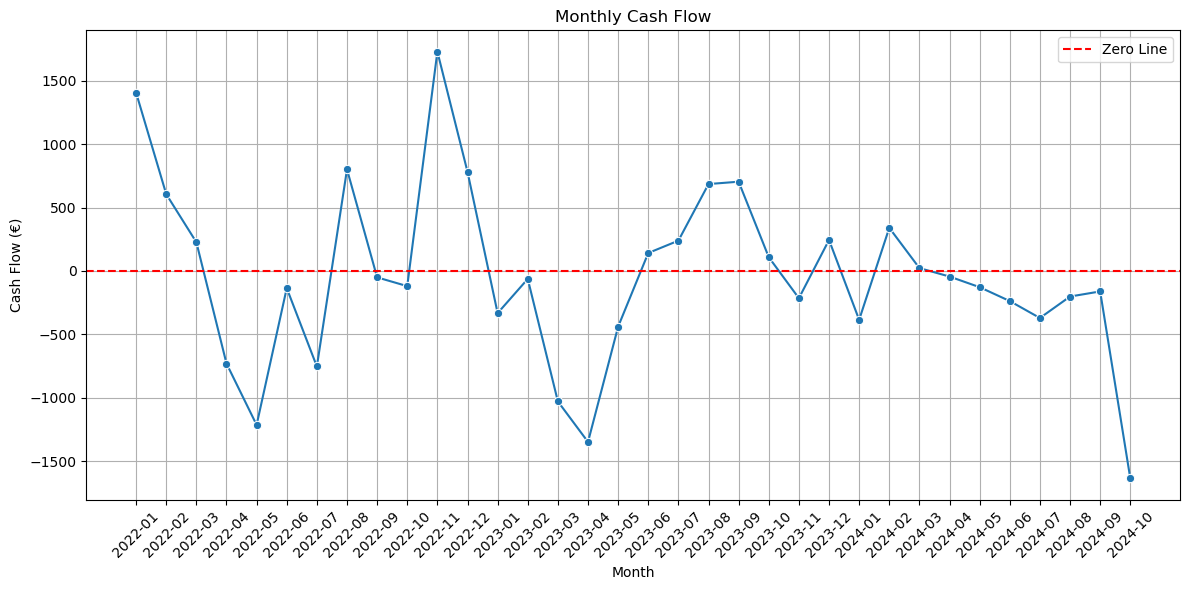

'/Users/tillo/Repositoriums/FinanceGrouper/plots/cash_flow_volatility.png'

In [66]:
# Calculates and visualizes cash flow stability over time
cash_flow_volatility(df, plots_path)

# D. 11 Income Sources Breakdown
Break down the sources of income (e.g., salary, refunds) by Zahlungspflichtige*r and analyze which contribute the most.

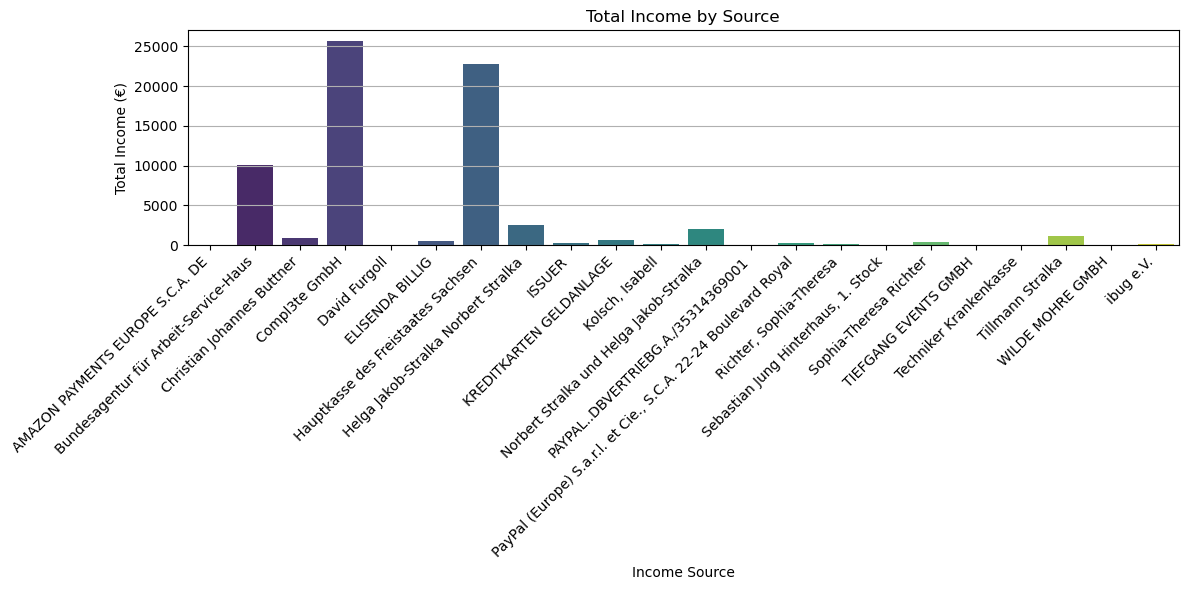

'/Users/tillo/Repositoriums/FinanceGrouper/plots/income_by_source.png'

In [67]:
# Analyzes and visualizes income sources with bar plots
income_by_source(df, plots_path)

# D. 12 Income Expenses

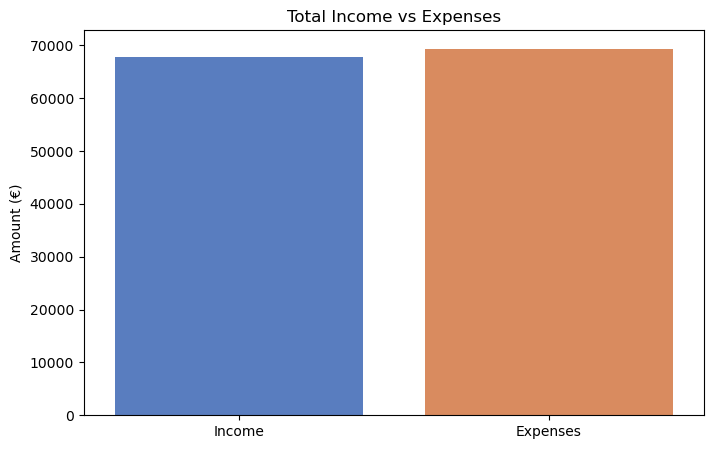

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_total_income_expenses.png'

In [68]:

plot_total_income_expenses(df, plots_path)

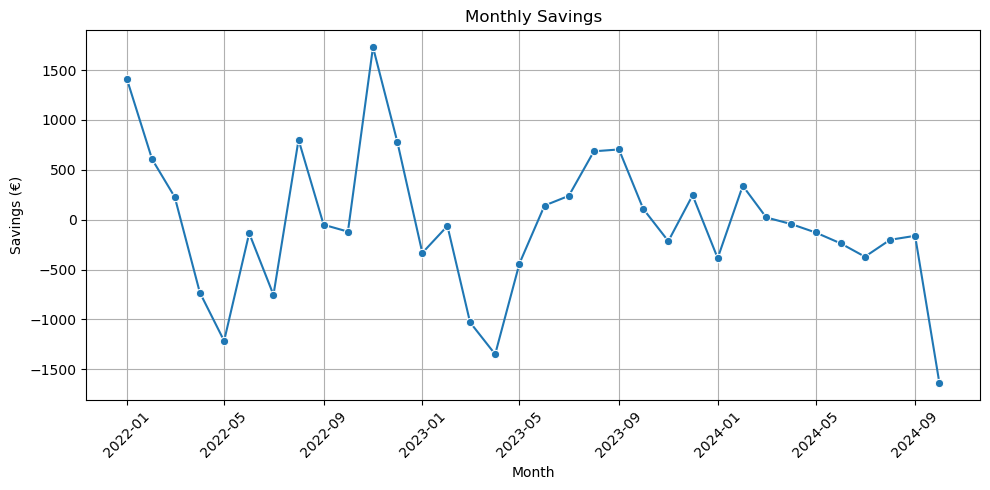

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_monthly_savings.png'

In [69]:


# Example execution
# Assuming 'df' is your DataFrame containing financial transactions
plot_monthly_savings(df, plots_path)

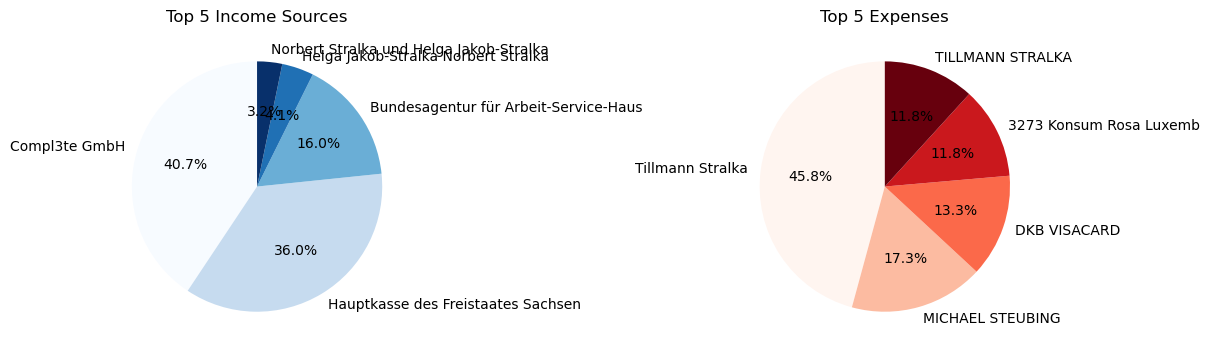

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_largest_expenses_income.png'

In [70]:

# Example execution
plot_largest_expenses_income(df, plots_path)



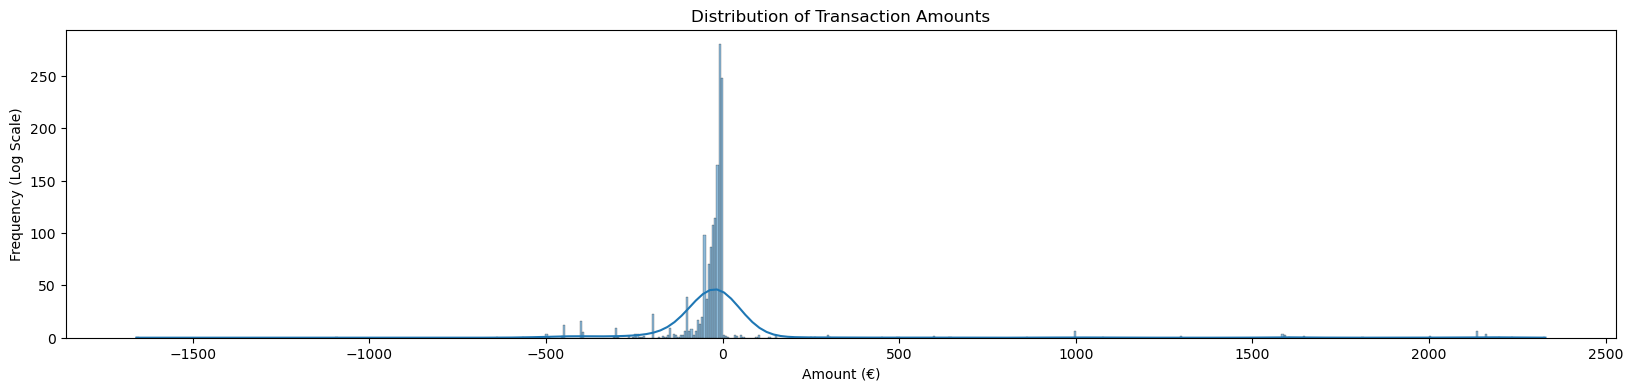

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_transaction_distribution.png'

In [71]:


plot_transaction_distribution(df, plots_path)    

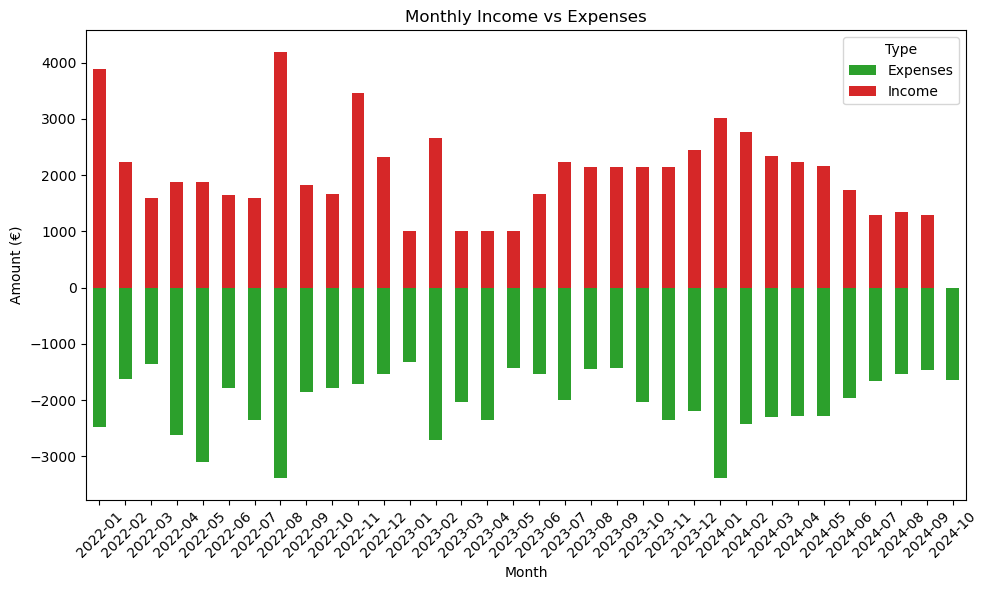

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_monthly_income_vs_expenses.png'

In [72]:

plot_monthly_income_vs_expenses(df, plots_path)

# E. Writing all the text output and images into a pdf for an overview sheet
- iterating through all functions seen above 
- iterating through all the plots which are saved in the plots folder 
- write it all down in a pdf and save it in reports 

In [73]:

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

# PDF erstellen
c = canvas.Canvas("reportlab_report.pdf", pagesize=A4)

# UTF-8 kompatible Schrift setzen (Helvetica oder andere Standardschriften)
c.setFont("Helvetica", 12)

# Text mit Euro-Symbol hinzufügen
c.drawString(100, 750, "Preis: 50,00 €")  # UTF-8 funktioniert direkt

# PDF speichern
c.save()
print("PDF erstellt: reportlab_report.pdf")

PDF erstellt: reportlab_report.pdf


In [74]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from PIL import Image

def save_to_pdf(text_functions, plot_functions, output_pdf_path):
    # Erstelle das PDF-Dokument
    c = canvas.Canvas(output_pdf_path, pagesize=A4)
    width, height = A4
    current_y = height - 40  # Startpunkt Y-Achse (40 pt Abstand nach oben)

    # Kopfzeile hinzufügen
    c.setFont("Helvetica-Bold", 14)
    c.drawString(200, current_y, "Financial Report")
    current_y -= 20  # Abstand für die Kopfzeile

    # Text hinzufügen
    c.setFont("Helvetica", 12)
    for text_function in text_functions:
        output = text_function()
        text_lines = output.split('\n')  # Zeilenumbrüche behandeln
        for line in text_lines:
            c.drawString(40, current_y, line)
            current_y -= 15  # Zeilenhöhe verringern
            if current_y < 40:  # Wenn die Seite voll ist, füge eine neue Seite hinzu
                c.showPage()
                current_y = height - 40

    # Bilder (Plots) hinzufügen
    for plot_function in plot_functions:
        plot_path = plot_function()
        img = Image.open(plot_path)
        img_width, img_height = img.size

        # Berechne skalierte Größe für das Bild
        max_width = width - 80  # Randabstand links/rechts 40 pt
        max_height = 300  # Maximalhöhe des Bildes
        ratio = min(max_width / img_width, max_height / img_height)
        img_width = int(img_width * ratio)
        img_height = int(img_height * ratio)

        # Bild hinzufügen
        c.drawImage(plot_path, 40, current_y - img_height, width=img_width, height=img_height)
        current_y -= img_height + 20  # Abstand nach dem Bild

        if current_y < 40:  # Wenn die Seite voll ist, füge eine neue Seite hinzu
            c.showPage()
            current_y = height - 40

    # PDF speichern
    c.save()
    print(f"PDF saved to {output_pdf_path}")


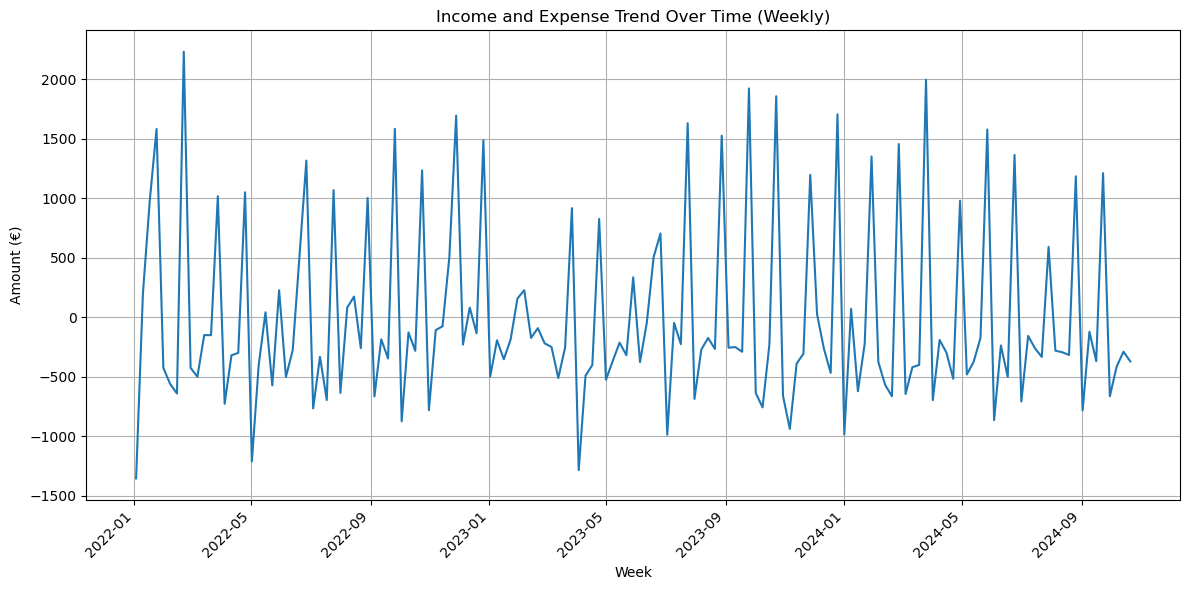

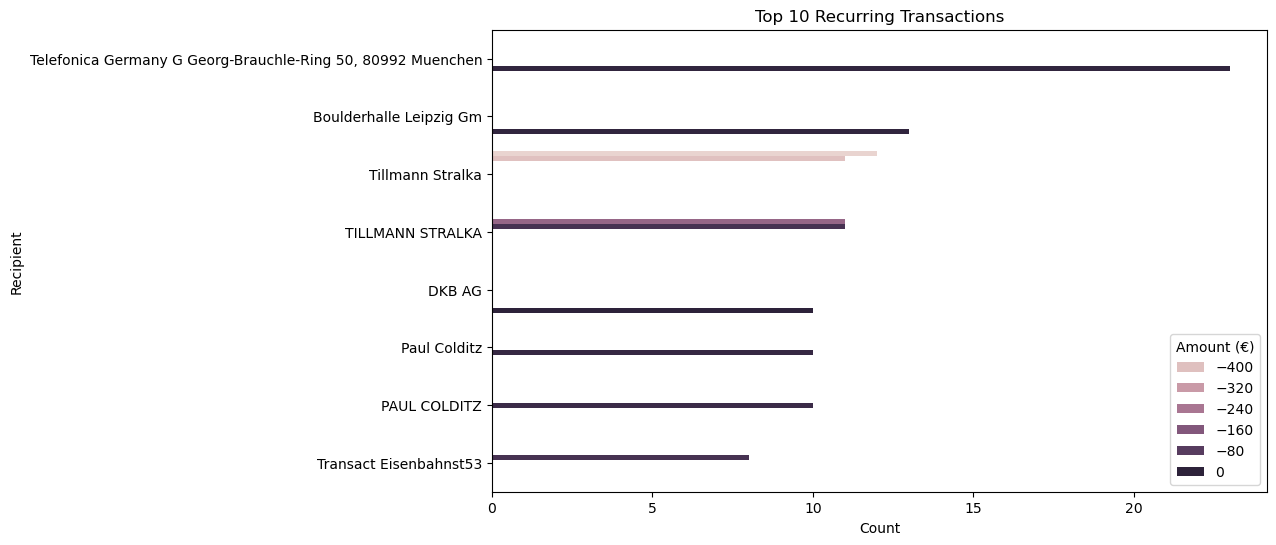

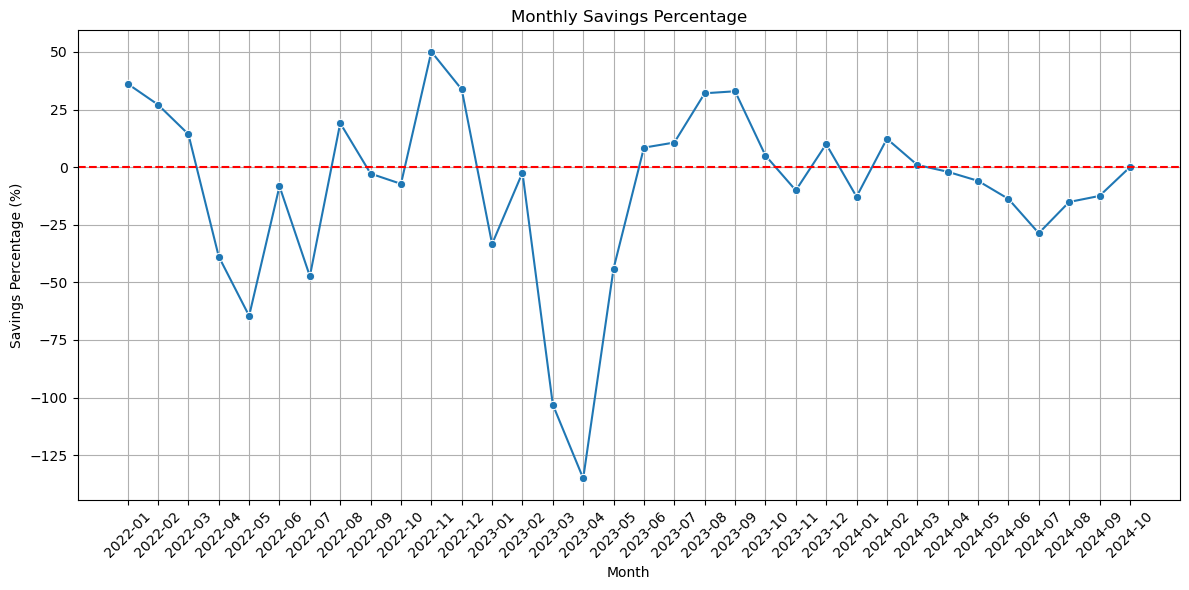

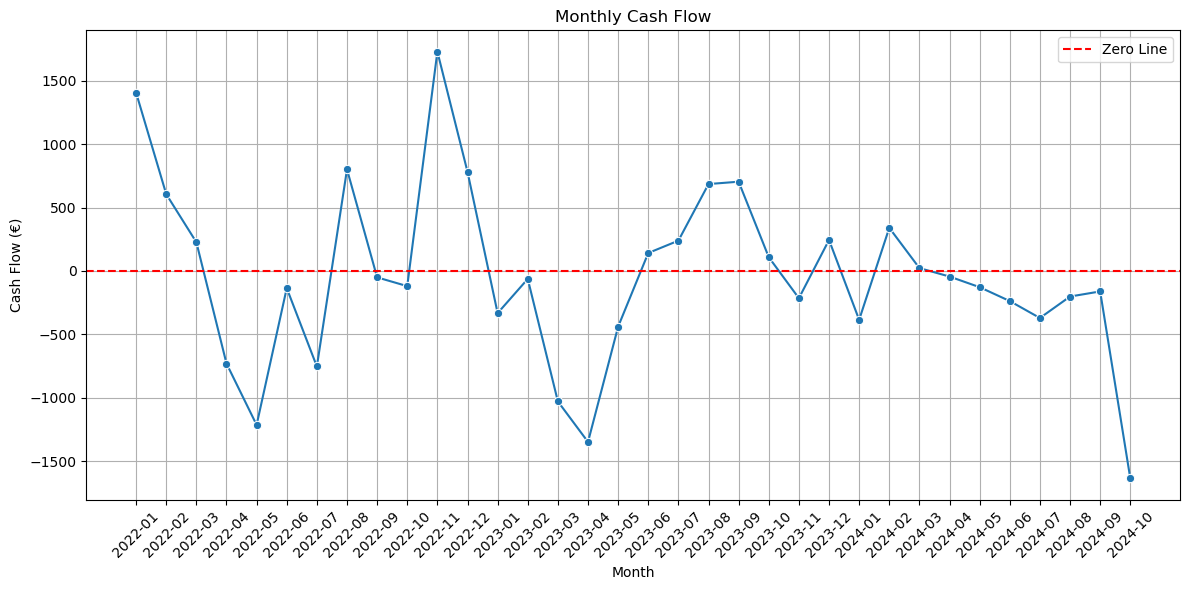

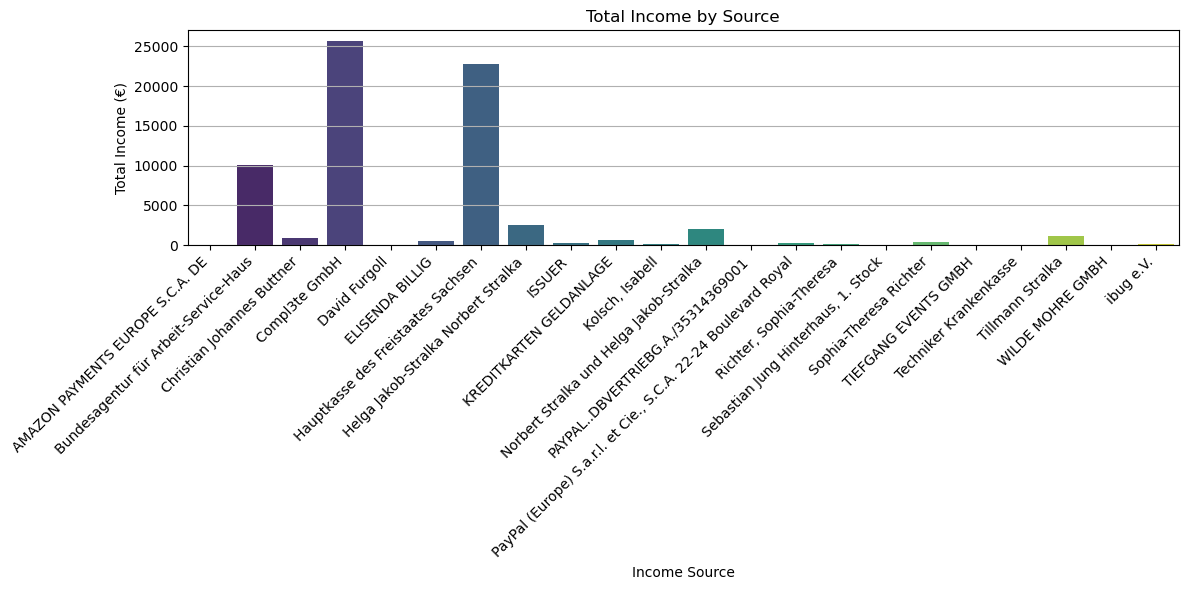

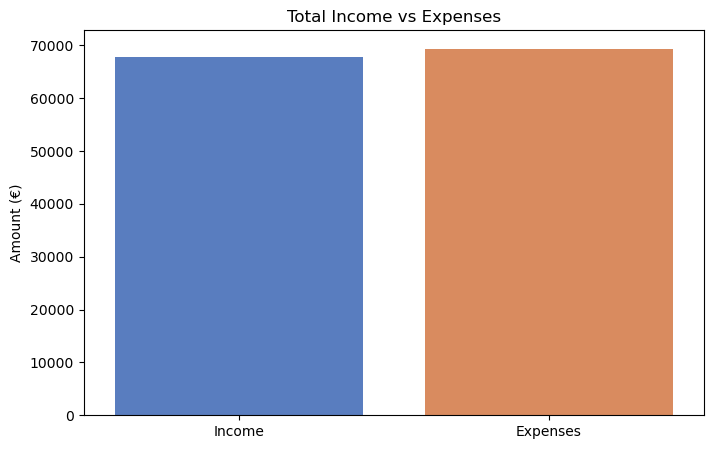

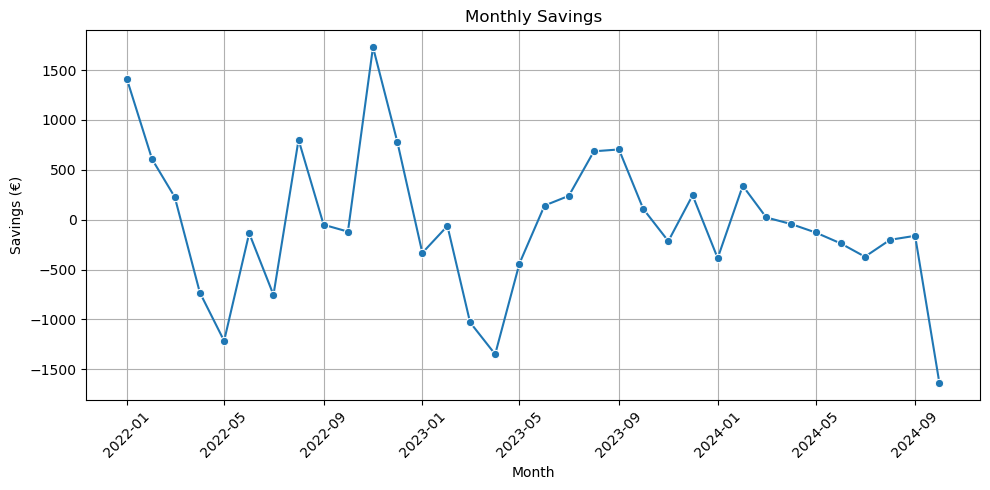

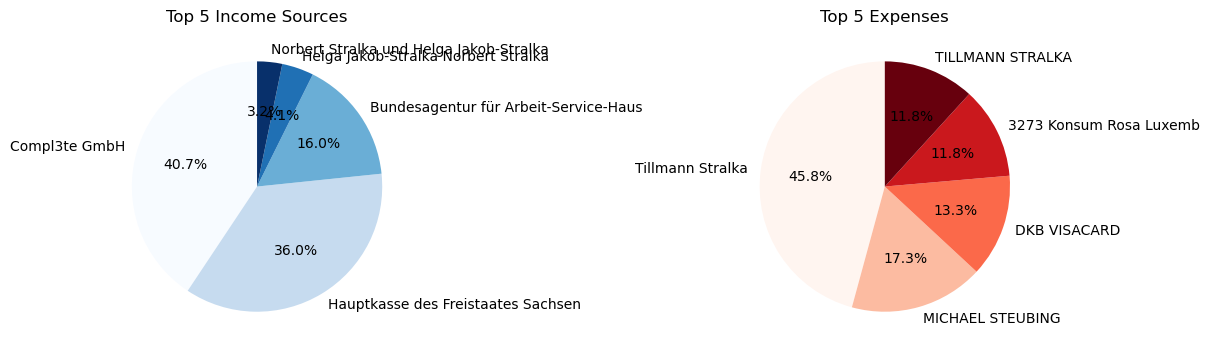

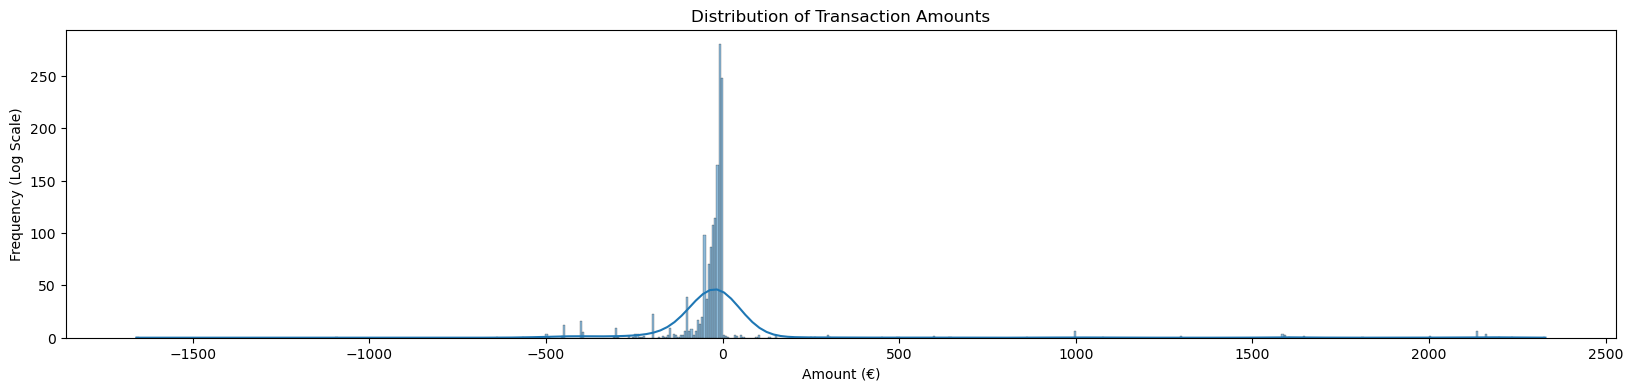

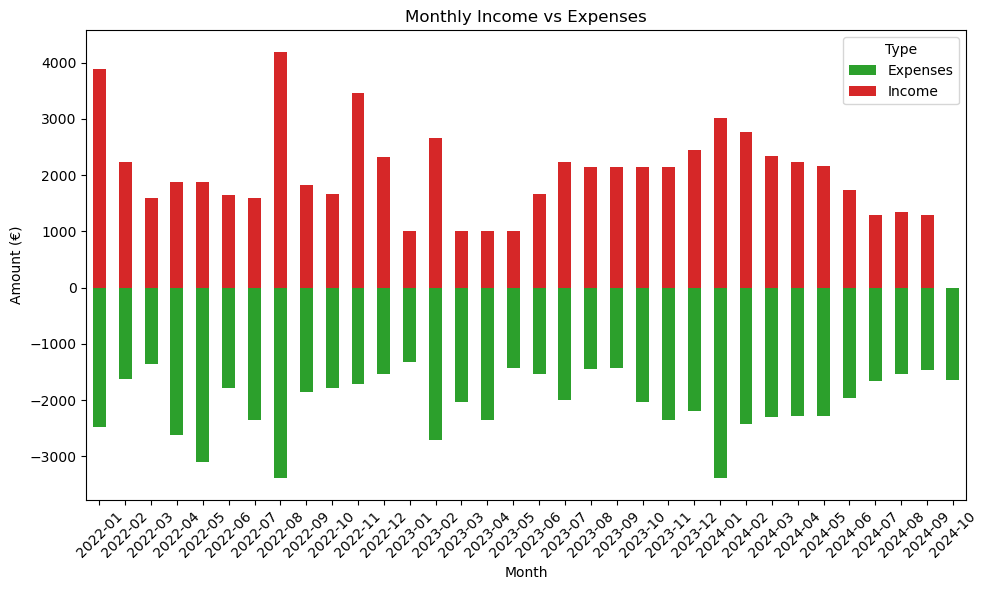

PDF saved to /Users/tillo/Repositoriums/FinanceGrouper/reports/financial_report.pdf


In [78]:

# Hauptprogramm
if __name__ == "__main__":
    text_functions = [
        lambda: basic_analysis(df),
        #analyze_by_category(df),
        #average_monthly_stats(df),
        #detect_recurring_transactions(df),
        #expense_income_ratio(df),
        #expenses_by_recipient(df),
        #detect_outliers(df),
        ]
    plot_functions = [
        lambda: income_expense_trend(df, plots_path),
        lambda: plot_recurring_summary(recurring_summary, plots_path),
        lambda: savings_percentage(df, plots_path),
        lambda: cash_flow_volatility(df, plots_path),
        lambda: income_by_source(df, plots_path),
        lambda: plot_total_income_expenses(df, plots_path),
        lambda: plot_monthly_savings(df, plots_path),
        lambda: plot_largest_expenses_income(df, plots_path),
        lambda: plot_transaction_distribution(df, plots_path)  ,
        lambda: plot_monthly_income_vs_expenses(df, plots_path)
        ]


    output_pdf_path = os.path.join(report_path, "financial_report.pdf")
    save_to_pdf(text_functions, plot_functions, output_pdf_path)



# Next possible steps: 
# Man könnte noch alle adressen rausnehmen 
# Den DF nach Datum ascending ordnen, damit irgendwelche komischen ausstehenden zahlungen der DKB an den richtigen tag kommen 
# Relableing 
# Time Series analysis of income with prediction
# All functions in the src file -> better overview 
# Make all the output into a text file with nice formating 
# Save all the plots also in the overview file (maybe rtf??)
# Make categorizer 
# Execute this with a dummy file into the data bevore publishing 
https://www.mockaroo.com/
# Deployment of already existing machine learning models for word categorizing: German Bert 

# 16. Categorize the income and expanses 

# Idee wie mit torch ein modell trainiert wird das mir die categorisierung abnehmen kann 

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Beispiel-Daten für Verwendungszwecke und Kategorien
texts = ["Kauf bei Amazon", "Krankenhauskosten", "Taxi-Gebühr", "Lebensmitteleinkauf", "Spende an WWF"]
labels = [2, 0, 1, 3, 4]  # Beispiel-Kategorien: 0 = Gesundheit, 1 = Transport, 2 = Online-Handel, 3 = Lebensmittel, 4 = Spenden

# Kategorien festlegen
category_names = ["Gesundheit", "Transport", "Online-Handel", "Lebensmittel", "Spenden"]

# Tokenizer und Modell laden
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=len(category_names))

# Daten als Dataset formatieren
class PurposeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {key: val.squeeze() for key, val in encoding.items()}, torch.tensor(label)

# Train- und Test-Daten erstellen
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

train_dataset = PurposeDataset(train_texts, train_labels, tokenizer)
val_dataset = PurposeDataset(val_texts, val_labels, tokenizer)

# Training konfigurieren
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Training durchführen
trainer.train()

# Beispiel für die Kategorisierung neuer Texte
def classify_text(text):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
    outputs = model(**encoding)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return category_names[predicted_class_id]

# Beispiel-Anwendung
new_text = "Zahlung an die Krankenkasse"
print(f"Kategorie für '{new_text}': {classify_text(new_text)}")


## Breakdown by Category
We use some heuristics on the tranasaction details to put them into different categories.
All transactions within a category will be aggregated for a better overall analysis.
You may need to check the print output of the next cell and possibly adapt the mapping function for a better categorisation.

**the text will be lower cased before categorisation**

**Feel free to change these heuristic mappings - or adapt the code to map according to specififc transaction details.**

In [ ]:
categories = {
    "eat_out_or_get_food": [
        "restaurant",
        "gastro",
        "dean david",
        "cafe",
        "baeckerei",
        "coffee fellows",
        "jim block",
        "don qui",
        "Osteria",
        "subway",
        "backhaus",
        "burger king",
        "campus suite",
        "juice.more",
        "Backerei",
        "Avni Terhani",
        "vegan",
        "thai",
        "indisch",
    ],
    "alltag_laden": [
        "lidl",
        "aldi",
        "edeka",
        "alnatura",
        "rewe",
        "vollcorner",
    ],
    "spezial_laden": [
        "karstadt",
        "galeria",
        "kaufhof",
        "mueller",
        "migros",
        "coop",
        "dm fil",
        "go asia",
        "Drogerie",
        "SUCKFUELL",
        "butlers",
        "Suckfull",
        "Bio-Market",
        "conrad m",
    ],
    "online_handel":[
        "otto",
        "conrad elec",
        "amzn mktp",
        "amazon",
    ],
    "transport": [
        "FERNVERKEHR",
        "flixbus",
        "PAYPAL .DBVERTR",
    ],
    "ausflug": [
        "hamburg",
        "Hotel",
        "PAYPAL .booking",
        "prague",
        "praha",
        "Tubingen",
    ],
    "project": [
        "openai",
        "google.cloud",
        "github",
    ],
    "freizeit": [
        "VOLKSBAD",
        "PAYPAL .SENNHEISER",
    ],
    "entertainment": [
        "magellan",
        "Amazon Prime",
        "paypal .steam",
        "netflix"
    ],
    "crypto": [
        "bitflyer",
        "coinbase"
    ],
    "health": [
        "apotheke",
        "Krankenversicherung",
    ],
    "cash": [
        "bargeld",
        "automat",
        "cash"
    ],
    "dkb": [
        "DKB",
        "KREDITBANK",
    ],
    "miete": [],
    "investment": [],
    "emergency_fund":[],
    "uncategorized": [
        "PayPal (Europe)",
    ],
    "card_payment": [],
    "minor": [ # populated automatically
    ]
}

def mapToCategory(x):
    # use these transaction details to map to a category
    p = x[party].lower()
    pt = x[posting_text].lower()
    c = x[cause].lower()
    
    # manual mappings
    if "WERTP. ABRECHN".lower() in c or "Depot ".lower() in c or "WERTPAPIER".lower() in c:
        return "investment"
    
    if "miete ".lower() in c:
        return "miete"
    
    if "KREDITKARTENABRECHNUNG".lower() in c:
        return "card_payment"
    
    # mappings by category
    for cat, cat_words in categories.items():
        if any(map(lambda r: r.lower() in p, cat_words)) or any(map(lambda r: r.lower() in pt, cat_words)):
            return cat
    
    # debitcard. may need adaptation
    if "Debitk.20 VISA Debit".lower() in c:
        return "card_payment"
    
    return p

data[category] = data.apply(lambda x: mapToCategory(x), axis=1)

print(len(data[category].unique()),"categories")

print("============ uncategorized =================")
s = 0
for x in data[category].unique():
    ok = False
    
    for cat in categories.keys():
        if x == cat:
            ok = True

    if not ok:
        print(x)
        idx = data[category] == x
        s = s + abs(data[idx][amount].sum())
        
print("================================ sum of uncategorized: ",s) # todo. this doesn't seem to make sense ... 🤔

Breakdown by category. (Ignored transactions below 10€).

In [ ]:
byCategory = data.groupby(category).agg({amount:"sum"}).sort_values(amount,ascending=False)
byCategory = byCategory[abs(byCategory[amount]) > 10]
    

costs = byCategory[byCategory[amount] < 0]
costs.loc[:,amount] = -costs[amount]

total_costs = costs[amount].sum()
costs.plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    autopct=lambda x: str(round(x/100*total_costs)) + "€ | " + str(round(x)) + "%",
    title=u'Nach Kategorie Aggregierte Kosten (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()

byCategory[byCategory[amount] > 0].plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    title=u'Nach Kategorie Aggregiertes Einkommen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


byCategory.plot.barh(
    figsize=(6,40),
    grid=True,
    title=u'Nach Kategorie Aggregierte Zahlungen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


### Category analysis

In [ ]:
def quick_category_analyse(cat,desc=party):
    excursions = data[data[category] == cat].sort_values(amount,ascending=True)

    excursions.plot.barh(
        figsize=(12,12),
        x=desc,
        y=amount,
        legend=None,
    )
    plt.show()

    return excursions

In [ ]:
quick_category_analyse("investment",desc=cause)

In [ ]:
quick_category_analyse("dkb", desc=cause)

In [ ]:
quick_category_analyse("ausflug")

In [ ]:
quick_category_analyse("card_payment")

In [ ]:
quick_category_analyse("transport")